In [1]:
from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)
IPythonConsole.molSize = 1700,1700
from ase.io import read, write
from ase.build import make_supercell
from ase.io import extxyz
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem import RWMol, AllChem
from rdkit.Chem import rdchem
import copy
import itertools
import json
import networkx as nx


2024.03.5


In [2]:
IPythonConsole.drawOptions.addAtomIndices = False

In [3]:
from utils_pbc import xyz2AC,AC2mol_PBC,transform_adj_matrix_PB
from utils import AC2mol
from periodic_smiels import mol_from_periodic_smiles,mol_to_periodic_smiles
from mini_tools import highlight_shared_bonds
from chouse_bonds import create_graph_from_bonds,find_symmetrical_triangles_or_all,create_adjacency_matrix,frag_func,guilatine,get_fragments_with_unique_ids, combine
from chem_rules import Rule1, Rule2, Rule3, Rule4

This code convert cif to mol graph

In [4]:

atoms = read("447.cif")
            
# Repeat the atoms to create a supercell
supercell = atoms.repeat((3,3,3))

# Obtain the scaled (fractional) positions of atoms
frac_positions = supercell.get_scaled_positions()

# Atom indices in the central unit cell
central_cell_indices = []

# Define boundaries of the central cell in terms of fractional coordinates
lower_bound = 1/3
upper_bound = 2/3

# Define a small tolerance to account for numerical inaccuracies
tolerance = 1e-16

# Loop over the fractional positions
for i, frac_pos in enumerate(frac_positions):
    in_central_cell = True

    # Check if the fractional position of the atom is within the central cell boundaries
    # for each dimension (x, y, z)
    for coord in frac_pos:
        if not (lower_bound- tolerance <= coord < upper_bound - tolerance):
            in_central_cell = False
            break

    if in_central_cell:
        central_cell_indices.append(i)
    
extxyz.write_extxyz("core.xyz",supercell,write_info=False, write_results=False,plain=True)

# Assuming central_indices contain indices of the atoms in the central cell
central_atoms_count = len(central_cell_indices)

# Number of atoms in the original cell
N = len(atoms)

# Total number of atoms in the supercell
M = len(supercell)

# Create a mapping where each atom in the central cell is 
# mapped to its corresponding atoms in the supercell
mapping = {idx: list(range(idx % N, M, N)) for idx in central_cell_indices}
    
# Create a reverse mapping where each atom in the supercell is 
# mapped to its corresponding atom in the central cell
reverse_mapping = {}
for central_atom_idx, cloned_atom_indices in mapping.items():
    for cloned_atom_idx in cloned_atom_indices:
        reverse_mapping[cloned_atom_idx] = central_atom_idx
# Load the supercell from an xyz file
#super_cell_mol = Chem.MolFromXYZFile("core.xyz")
super_cell_xyz = read("core.xyz")

adj, xyzs= xyz2AC(super_cell_xyz.get_atomic_numbers(),super_cell_xyz.get_positions(), 0, )
adj_new, adj_PBC=transform_adj_matrix_PB(adj,central_cell_indices, reverse_mapping)

# Convert the supercell to an editable mol
rw_mol2 = RWMol(xyzs)
# Iterate over all indices in the supercell in the reverse order
for idx in reversed(range(len(rw_mol2.GetAtoms()))):
    # If the index is not in the central_indices list, delete the atom
    if idx not in central_cell_indices:
        rw_mol2.RemoveAtom(idx)
atoms_new=[i.GetAtomicNum()for i in rw_mol2.GetAtoms()]
print(len(central_cell_indices) == len(rw_mol2.GetAtoms()))
new_mols = AC2mol_PBC(rw_mol2, adj_new ,adj_PBC, atoms_new, 0,
            allow_charged_fragments=False,
            use_graph=True,
            use_atom_maps=False)
test=new_mols[0]
print("Fragmet lenght: "+str(len(Chem.GetMolFrags(test, asMols=True,sanitizeFrags=False))))


#this is a trick to restore aromaticity
smiles = Chem.MolToSmiles(test, isomericSmiles=True,allHsExplicit=True)

#Lets find all the periodic bonds
list_b=[]
for bond in test.GetBonds():
    if bond.GetProp("isPeriodic")== "true":
        list_b.append(bond.GetIdx())

periodic_smiles=f'{smiles}|{list_b}'
m=mol_from_periodic_smiles(periodic_smiles)


#just to be safe
m1=copy.copy(m)
m1=Chem.AddHs(m1)

True
Fragmet lenght: 1


sometimes you have frgamented mol structure (failed cif->mol converison. We need to check for that)

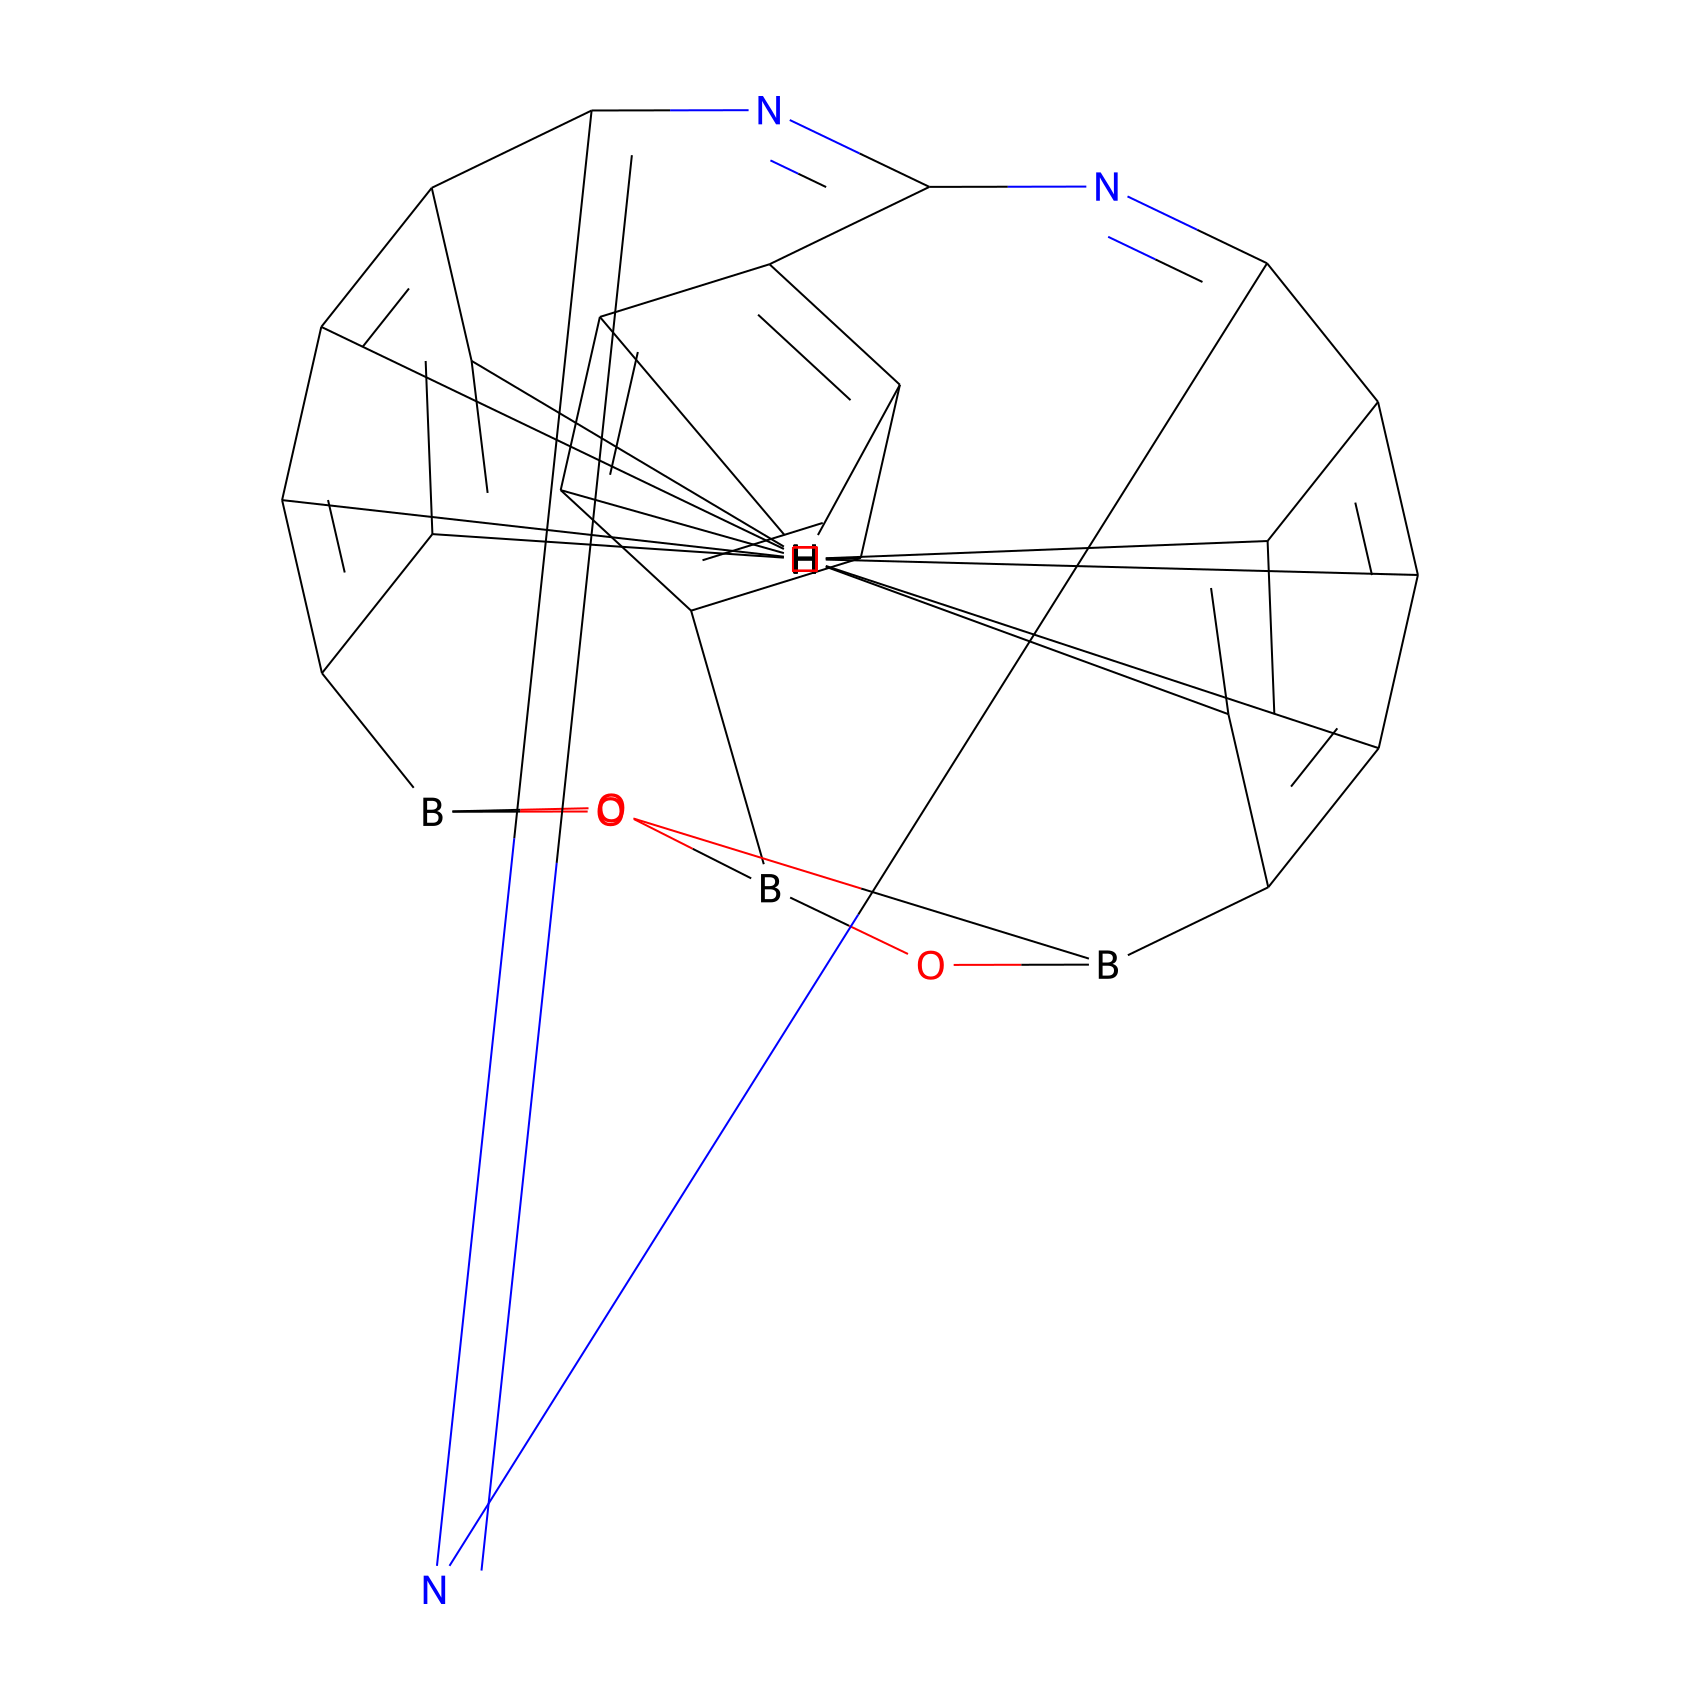

In [5]:
molser = Chem.GetMolFrags(m1, asMols=True)
len_cof_frag=len(molser)
for i, single_mol in enumerate(molser):
    if len(molser[i].GetAtoms()) ==len(molser[0].GetAtoms()):
        single_mol = Chem.AddHs(single_mol)
        Chem.SanitizeMol(single_mol)
    else:
        single_mol="nope"
single_mol

In [6]:
rules = [Rule1(), Rule4(), Rule2(), Rule3()]

In [8]:
if single_mol!="nope":


   
    out_bonds = set()
    current_mol = single_mol
    for rule in rules:
        matched_bonds, current_mol = rule.apply(current_mol,
                                                highlight_shared_bonds(single_mol)[1],highlight_shared_bonds(single_mol)[1],highlight_shared_bonds(single_mol)[2])
        
        out_bonds.update(matched_bonds)

    #here are all the bonds that satisfy our rules
    suspected_bonds = list(out_bonds)  # removes duplicates

    #some additional variables for later use
    mol=current_mol 
    mol_out=current_mol 

    # Generate bond fingerprints
    radius = 2
    fingerprint_dict = {}  # Assuming you've initialized this dictionary before

    for bond_id in suspected_bonds:
        bond = mol.GetBondWithIdx(bond_id)
        begin_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()
        
        # Generate fingerprints centered around the two atoms of the bond
        fp_begin = AllChem.GetMorganFingerprintAsBitVect(mol, radius, useFeatures=False,useBondTypes=False, fromAtoms=[begin_atom])
        fp_end = AllChem.GetMorganFingerprintAsBitVect(mol, radius, useFeatures=False,useBondTypes=False, fromAtoms=[end_atom])
        
        # Combine the two fingerprints with a logical OR
        combined_fp = fp_begin | fp_end
        # Convert to a hashable representation
        hashable_fp = combined_fp.ToBitString()
        fingerprint_dict[bond_id] = hashable_fp

    # Group bonds with identical fingerprint representations
    grouped_bonds = {}
    for bond_id, fp in fingerprint_dict.items():
        if fp not in grouped_bonds:
            grouped_bonds[fp] = []
        grouped_bonds[fp].append(bond_id)

    # Convert to list of lists format
    final_groups = [group for group in grouped_bonds.values() if len(group) > 1]

    if len(final_groups) > 1:
        # Sort by the size of the group and then by fingerprint value
        sorted_groups = sorted(final_groups, key=lambda g: (-len(g), fingerprint_dict[g[0]]))
        
        # The first group will be the one with the highest count and the smallest fingerprint value
        suspected_bonds = sorted_groups[0]

    # Creating the graph
    bond_list = suspected_bonds
    G = create_graph_from_bonds(mol, bond_list)


    matrix, nodes_order = create_adjacency_matrix(G)
    #result = find_smallest_labels(matrix, nodes_order)
    triangles_or_all = find_symmetrical_triangles_or_all(matrix, nodes_order)
    set_bonds_fin=set()
    for i in triangles_or_all:
        set_bonds_fin.update(i)



3
4
4
O


[08:17:30] DEPRECATION WARNING: please use MorganGenerator
[08:17:30] DEPRECATION WARNING: please use MorganGenerator
[08:17:30] DEPRECATION WARNING: please use MorganGenerator
[08:17:30] DEPRECATION WARNING: please use MorganGenerator
[08:17:30] DEPRECATION WARNING: please use MorganGenerator
[08:17:30] DEPRECATION WARNING: please use MorganGenerator
[08:17:30] DEPRECATION WARNING: please use MorganGenerator
[08:17:30] DEPRECATION WARNING: please use MorganGenerator
[08:17:30] DEPRECATION WARNING: please use MorganGenerator
[08:17:30] DEPRECATION WARNING: please use MorganGenerator
[08:17:30] DEPRECATION WARNING: please use MorganGenerator
[08:17:30] DEPRECATION WARNING: please use MorganGenerator


In [9]:
out=guilatine(mol_out,set_bonds_fin)
out_frag=Chem.GetMolFrags(out, asMols=True,sanitizeFrags=False)
fragy_list=frag_func(out_frag)

yps
yps


In [11]:
if len(get_fragments_with_unique_ids(fragy_list)) ==2:
    
    print(0)
    out_1_m=get_fragments_with_unique_ids(fragy_list)[0]
    out_2_m=get_fragments_with_unique_ids(fragy_list)[1]

    print(1)
    

    out_sm1=Chem.MolToSmiles(out_1_m)
    out_sm2=Chem.MolToSmiles(out_2_m)
    print(3)
    ll=Chem.MolFromSmiles(out_sm1)
    ll2=Chem.MolFromSmiles(out_sm2) 
    print(4)   
    ll.GetAtoms()
    ll2.GetAtoms()

    
    print(out_sm1)
    print(out_sm2)
    
    com=combine([out_1_m,out_2_m])
    com_smile=Chem.MolToSmiles(com)


    
    Chem.MolFromSmiles(com_smile)
    results = Chem.Draw.MolsToGridImage([out_1_m,out_2_m,com],maxMols=10,subImgSize=(700,700),legends=["amount:"+str(out_1_m.GetUnsignedProp("amount"))+", n_conncections:" + str(out_1_m.GetUnsignedProp("number_connections"))+", type" + str(out_1_m.GetUnsignedProp("type"))+", rule:" + str(out_1_m.GetUnsignedProp("rule")),"amount:"+str(out_2_m.GetUnsignedProp("amount"))+", n_conncections:" + str(out_2_m.GetUnsignedProp("number_connections"))+", type" + str(out_2_m.GetUnsignedProp("type"))+", rule:" + str(out_2_m.GetUnsignedProp("rule")), "n+l"],  returnPNG=False,molsPerRow=3)
    icof=447
    results.save("l_n_test/" + str(icof)+".png")
    text=str(icof)+" || "+"COFs_in_cell: "+str(len_cof_frag)+" || "+out_sm1+" ,"+"amount:"+str(out_1_m.GetUnsignedProp("amount"))+", n_conncections:" + str(out_1_m.GetUnsignedProp("number_connections"))+", type" + str(out_1_m.GetUnsignedProp("type"))+", rule:" + str(out_1_m.GetUnsignedProp("rule"))+" ||| "+ out_sm2+" ,""amount:"+str(out_2_m.GetUnsignedProp("amount"))+", n_conncections:" + str(out_2_m.GetUnsignedProp("number_connections"))+", type" + str(out_2_m.GetUnsignedProp("type"))+", rule:" + str(out_2_m.GetUnsignedProp("rule"))+" comb_smiles: " +com_smile
    
    print("+COF:"+str(icof))
    
elif len(get_fragments_with_unique_ids(out_frag)) >2:
    print("more then 2 fragments in the output")
    print("-COF:"+str(icof))


0
1
3
4
[H]c1c([H])c([H])c(-c2nc(-c3c([H])c([H])c([H])c([H])c3[H])nc(-c3c([H])c([H])c([H])c([H])c3[H])n2)c([H])c1[H]
[H]B1OB([H])OB([H])O1
one
one2
+COF:447
